In [27]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from model import SimpleLSTM, SpacedLSTM
from lstm_functions import quantile_loss, predict_model, plot_forecasts, plot_training_validation_loss
from data_prep import prepare_data

In [40]:
file_path = '../formatted_data/formatted_data_new.csv'
future_cols = ["Demand", "Wind_Generation", "PV_Generation", "Wind_Prediction", "Predicted_Demand_Renewables", "Hour_Sin", "Hour_Cos", "Day_Sin", "Day_Cos", "Month_Sin", "Month_Cos", "Predicted_Demand"]
quantiles = [0.2, 0.5, 0.8]



import pandas as pd

# Load your dataset
data = pd.read_csv(file_path)

# Calculate differences
data['calculated_da_id'] = data['DA'] - data['ID']
data['calculated_id_da'] = data['ID'] - data['DA']

# Compare with the existing 'Diff' column
data['diff_matches_da_id'] = data['Diff'] == data['calculated_da_id']
data['diff_matches_id_da'] = data['Diff'] == data['calculated_id_da']

# Summarize the results
matches_da_id = data['diff_matches_da_id'].sum()
matches_id_da = data['diff_matches_id_da'].sum()
total_rows = len(data)

print(f"Rows matching DA - ID: {matches_da_id}/{total_rows}")
print(f"Rows matching ID - DA: {matches_id_da}/{total_rows}")

# Identify mismatched rows for further inspection
mismatched_rows = data[~data['diff_matches_da_id'] & ~data['diff_matches_id_da']]
print("Mismatched rows:")
print(mismatched_rows.head())


Rows matching DA - ID: 13951/16799
Rows matching ID - DA: 8/16799
Mismatched rows:
      Year  Month  Day  Hour      DA      ID       Demand  Wind_Generation  \
20  2023.0    1.0  1.0  20.0   19.51    8.33  26330.83333          10431.5   
23  2023.0    1.0  1.0  23.0   40.07   41.97  21170.25000          10982.5   
24  2023.0    1.0  1.0  24.0   16.00    6.28  21170.25000          10982.5   
31  2023.0    1.0  2.0   7.0   85.00   84.80  25991.25000           4101.0   
34  2023.0    1.0  2.0  10.0  131.58  131.31  28950.08333           1998.5   

    PV_Generation  Predicted_Demand  ...  Month_Cos  Year_Scaled   Diff  \
20       5.000000           23907.3  ...   0.866025          0.6  11.18   
23       4.416667           19098.8  ...   0.866025          0.6  -1.90   
24       4.416667           19098.8  ...   0.866025          0.6   9.72   
31      50.083333           23128.0  ...   0.866025          0.6   0.20   
34    3999.333333           25333.5  ...   0.866025          0.6   0.27  

# Simple Benchmark Model

In [4]:

dense_lookback = 48  # Last 48 hours
forecast_horizon = 24  # Predict next 24 hours
target_col = "DA"


In [11]:
# Prepare datasets
(
    train_dense_past,
    train_future,
    train_pca,
    train_targets,
    val_dense_past,
    val_future,
    val_pca,
    val_targets,
    test_dense_past,
    test_future,
    test_pca,
    test_targets,
    target_scaler,
) = prepare_data(
    file_path=file_path,
    dense_lookback=dense_lookback,
    spaced_lookback=0,
    forecast_horizon=forecast_horizon,
    future_cols=future_cols,
    target_col=target_col,
    spaced=False,
)
print(train_dense_past.shape, train_future.shape, train_pca.shape, train_targets.shape)
# Create DataLoaders
train_loader = DataLoader(
    TensorDataset(train_dense_past, train_future, train_pca, train_targets),
    batch_size=64,
    shuffle=True,
)
val_loader = DataLoader(
    TensorDataset(val_dense_past, val_future, val_pca, val_targets),
    batch_size=64,
    shuffle=False,
)
test_loader = DataLoader(
    TensorDataset(test_dense_past, test_future, test_pca, test_targets),
    batch_size=1,
    shuffle=False,
)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = SimpleLSTM(
    past_input_size=train_dense_past.shape[2],
    future_input_size=len(future_cols),
    pca_input_size=train_pca.shape[1],
    hidden_size=128,
    num_layers=2,
    dropout=0.3,
    past_horizons=train_dense_past.shape[1],
    forecast_horizon=forecast_horizon,
    quantiles=quantiles,
).to(device)

optimizer1 = torch.optim.AdamW(model1.parameters(), lr=0.0005, weight_decay=1e-4)

# Training and Validation Function for Forked Training
def train_and_val(train_loader, val_loader, num_epochs, model, optimizer, quantiles, device):
    """
    Trains and validates the model using both past and future data simultaneously.
    """
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_loss = 0
        for batch_idx, (past_inputs, future_inputs, pca_inputs, targets) in enumerate(train_loader):
            past_inputs, future_inputs, pca_inputs, targets = (
                past_inputs.to(device).float(),
                future_inputs.to(device).float(),
                pca_inputs.to(device).float(),
                targets.to(device).float(),
            )

            optimizer.zero_grad()
            forecasts = model(past_inputs, future_inputs, pca_inputs)
            loss = quantile_loss(forecasts, targets, quantiles)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= (batch_idx + 1)
        train_losses.append(train_loss)

        # Validation Phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_idx, (past_inputs, future_inputs, pca_inputs, targets) in enumerate(val_loader):
                past_inputs, future_inputs, pca_inputs, targets = (
                    past_inputs.to(device).float(),
                    future_inputs.to(device).float(),
                    pca_inputs.to(device).float(),
                    targets.to(device).float(),
                )

                forecasts = model(past_inputs, future_inputs, pca_inputs)
                loss = quantile_loss(forecasts, targets, quantiles)
                val_loss += loss.item()

        val_loss /= (batch_idx + 1)
        val_losses.append(val_loss)

        print(
            f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}"
        )

    # Plot Training and Validation Losses
    plot_training_validation_loss(train_losses, val_losses)
    return model, train_losses, val_losses

usable_hours: 16607
torch.Size([11624, 168, 18]) torch.Size([11624, 24, 12]) torch.Size([11624, 11]) torch.Size([11624, 24, 1])


Epoch [1/25], Training Loss: 0.1674, Validation Loss: 0.1267
Epoch [2/25], Training Loss: 0.1072, Validation Loss: 0.0700
Epoch [3/25], Training Loss: 0.0674, Validation Loss: 0.0589
Epoch [4/25], Training Loss: 0.0584, Validation Loss: 0.0578
Epoch [5/25], Training Loss: 0.0538, Validation Loss: 0.0534
Epoch [6/25], Training Loss: 0.0517, Validation Loss: 0.0496
Epoch [7/25], Training Loss: 0.0496, Validation Loss: 0.0489
Epoch [8/25], Training Loss: 0.0484, Validation Loss: 0.0487
Epoch [9/25], Training Loss: 0.0469, Validation Loss: 0.0488
Epoch [10/25], Training Loss: 0.0466, Validation Loss: 0.0482
Epoch [11/25], Training Loss: 0.0461, Validation Loss: 0.0489
Epoch [12/25], Training Loss: 0.0457, Validation Loss: 0.0493
Epoch [13/25], Training Loss: 0.0443, Validation Loss: 0.0471
Epoch [14/25], Training Loss: 0.0438, Validation Loss: 0.0476
Epoch [15/25], Training Loss: 0.0435, Validation Loss: 0.0468
Epoch [16/25], Training Loss: 0.0433, Validation Loss: 0.0480
Epoch [17/25], Tr

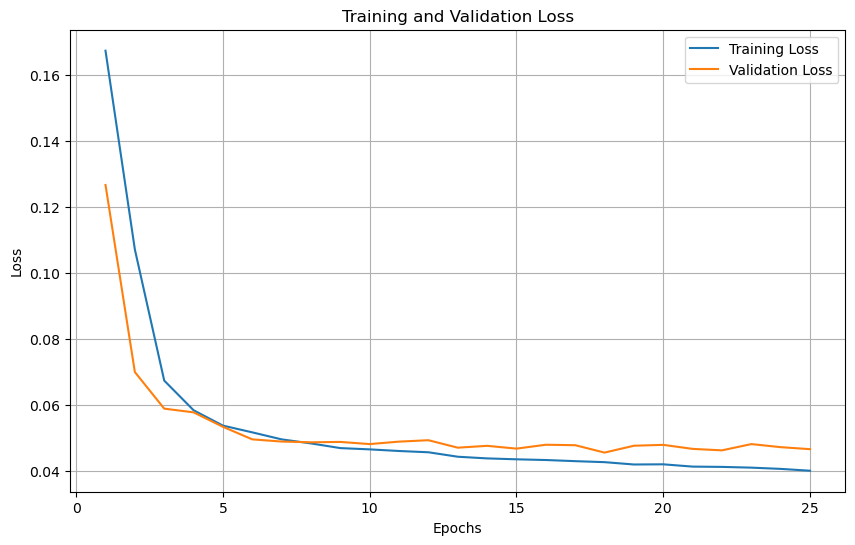

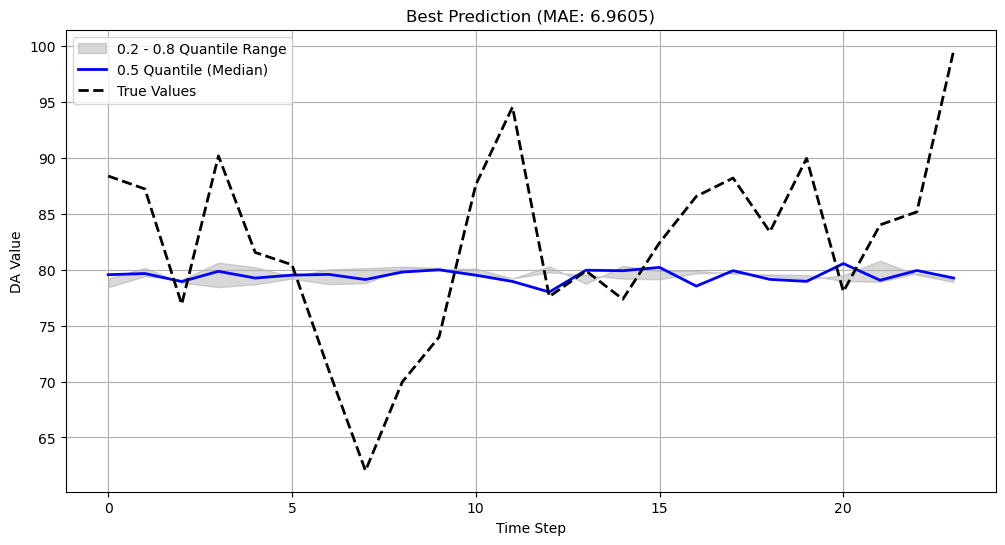

MAE: 6.9605
Pinball Loss: 10.5459
Coverage: 0.0000


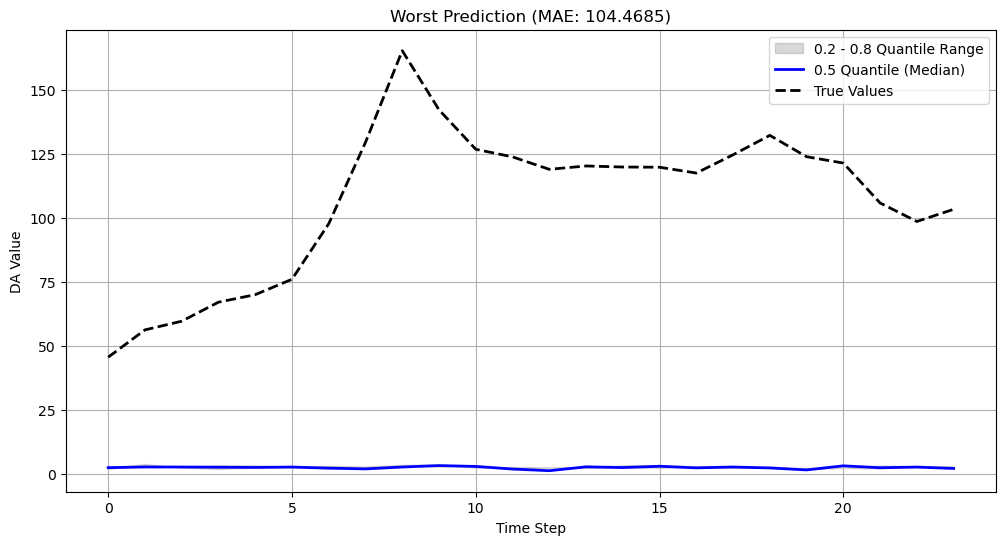

MAE: 104.4685
Pinball Loss: 156.5154
Coverage: 0.0000
Average MAE: 30.1932


In [12]:
# Train model
simple_model, train_losses, val_losses = train_and_val(
    train_loader, val_loader, num_epochs=25, model=model1, optimizer=optimizer1, quantiles=quantiles, device=device
)
# # Predict
forecast_inv, true_inv = predict_model(simple_model, test_loader, target_scaler, quantiles=quantiles, forecast_horizon=24, device=device)

# # Plot results
plot_forecasts(forecast_inv, true_inv, quantiles=quantiles, forecast_horizon=24)

# 3 Spaced Models for DA, ID and Diff

In [29]:
# Parameters
dense_lookback = 168
spaced_lookback = 180*24
target_cols = ["DA", "ID", "Diff"]

In [30]:
def train_and_val(train_loader, val_loader, num_epochs, model, optimizer, quantiles, device):
    """
    Train and validate the SpacedLSTM model using dense, spaced, and future data.
    
    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        num_epochs (int): Number of epochs for training.
        model (nn.Module): The SpacedLSTM model to train.
        optimizer (torch.optim.Optimizer): Optimizer for model training.
        quantiles (list): List of quantiles for loss calculation.
        device (torch.device): Device to run training on ('cpu' or 'cuda').
    
    Returns:
        model (nn.Module): The trained model.
        train_losses (list): List of average training losses per epoch.
        val_losses (list): List of average validation losses per epoch.
    """
    train_losses, val_losses = [], []

    for epoch in range(1, num_epochs + 1):
        # Training Phase
        model.train()
        epoch_train_loss = 0
        for batch_idx, (dense_inputs, spaced_inputs, future_inputs, pca_inputs, targets) in enumerate(train_loader):
            # Move data to the specified device
            dense_inputs, spaced_inputs, future_inputs, pca_inputs, targets = (
                dense_inputs.to(device).float(),
                spaced_inputs.to(device).float(),
                future_inputs.to(device).float(),
                pca_inputs.to(device).float(),
                targets.to(device).float(),
            )

            # Forward pass
            optimizer.zero_grad()
            forecasts = model(dense_inputs, spaced_inputs, future_inputs, pca_inputs)

            # Calculate loss
            loss = quantile_loss(targets, forecasts, quantiles)

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        # Average training loss for the epoch
        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)

        # Validation Phase
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch_idx, (dense_inputs, spaced_inputs, future_inputs, pca_inputs, targets) in enumerate(val_loader):
                # Move data to the specified device
                dense_inputs, spaced_inputs, future_inputs, pca_inputs, targets = (
                    dense_inputs.to(device).float(),
                    spaced_inputs.to(device).float(),
                    future_inputs.to(device).float(),
                    pca_inputs.to(device).float(),
                    targets.to(device).float(),
                )

                # Forward pass
                forecasts = model(dense_inputs, spaced_inputs, future_inputs, pca_inputs)

                # Calculate loss
                loss = quantile_loss(targets, forecasts, quantiles)
                epoch_val_loss += loss.item()

        # Average validation loss for the epoch
        epoch_val_loss /= len(val_loader)
        val_losses.append(epoch_val_loss)

        # Log epoch results
        print(
            f"Epoch [{epoch}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}"
        )

    # Plot Training and Validation Losses
    plot_training_validation_loss(train_losses, val_losses)

    return model, train_losses, val_losses

--------------------------------------------------
Training model for target: DA
--------------------------------------------------
usable_hours: 12455
Epoch [1/30], Training Loss: 0.7768, Validation Loss: 0.2142
Epoch [2/30], Training Loss: 0.2217, Validation Loss: 0.1780
Epoch [3/30], Training Loss: 0.1584, Validation Loss: 0.1288
Epoch [4/30], Training Loss: 0.1373, Validation Loss: 0.1156
Epoch [5/30], Training Loss: 0.1284, Validation Loss: 0.1072
Epoch [6/30], Training Loss: 0.1230, Validation Loss: 0.1059
Epoch [7/30], Training Loss: 0.1198, Validation Loss: 0.1120
Epoch [8/30], Training Loss: 0.1169, Validation Loss: 0.1070
Epoch [9/30], Training Loss: 0.1146, Validation Loss: 0.1131
Epoch [10/30], Training Loss: 0.1121, Validation Loss: 0.1147
Epoch [11/30], Training Loss: 0.1096, Validation Loss: 0.1098
Epoch [12/30], Training Loss: 0.1064, Validation Loss: 0.1094
Epoch [13/30], Training Loss: 0.1041, Validation Loss: 0.1159
Epoch [14/30], Training Loss: 0.0995, Validation Lo

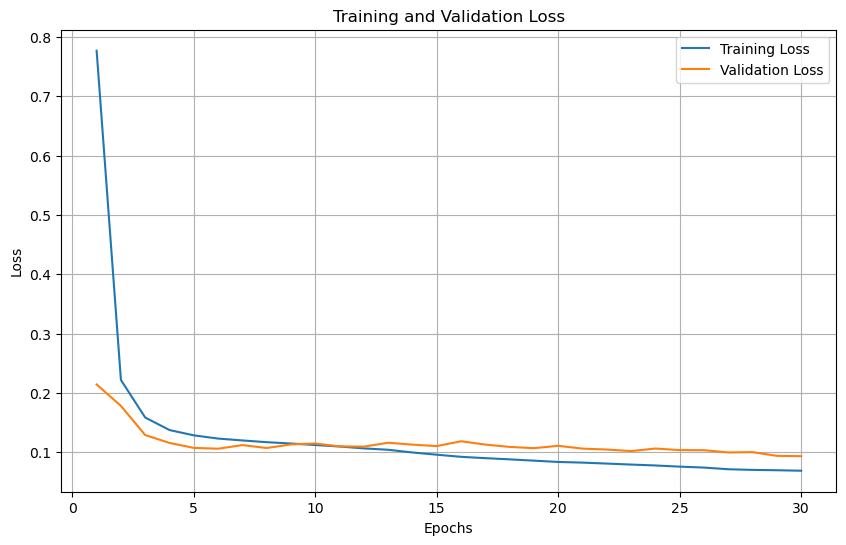

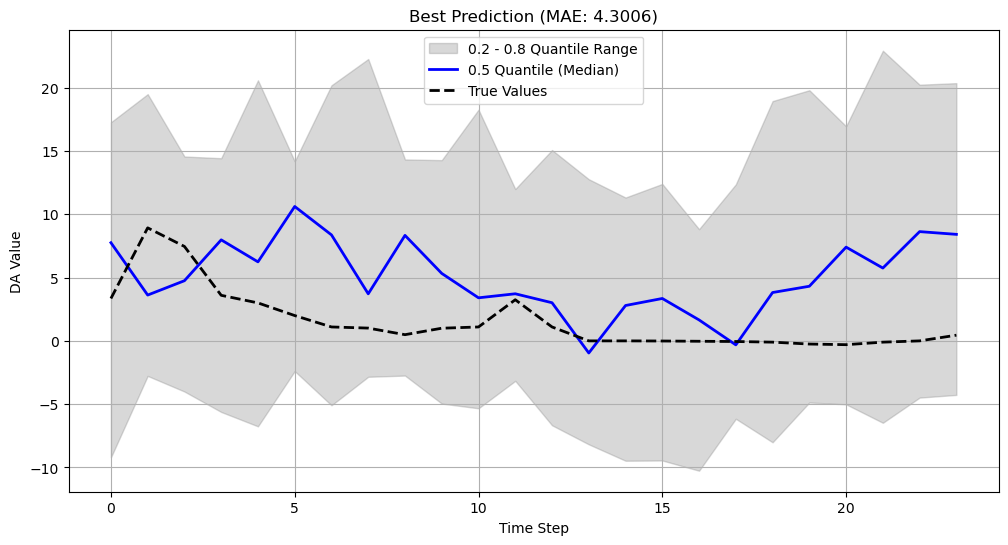

MAE: 4.3006
Pinball Loss: 6.5834
Coverage: 1.0000


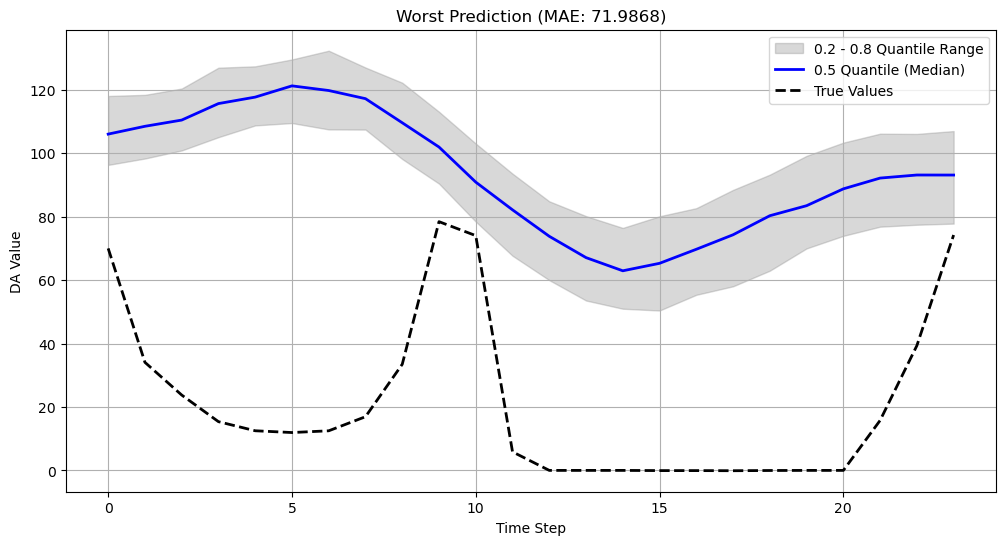

MAE: 71.9868
Pinball Loss: 100.1204
Coverage: 0.0000
Average MAE: 29.7253
--------------------------------------------------
Training model for target: ID
--------------------------------------------------
usable_hours: 12455
Epoch [1/30], Training Loss: 0.7189, Validation Loss: 0.1502
Epoch [2/30], Training Loss: 0.1708, Validation Loss: 0.0888
Epoch [3/30], Training Loss: 0.1091, Validation Loss: 0.0871
Epoch [4/30], Training Loss: 0.0924, Validation Loss: 0.0781
Epoch [5/30], Training Loss: 0.0856, Validation Loss: 0.0778
Epoch [6/30], Training Loss: 0.0815, Validation Loss: 0.0742
Epoch [7/30], Training Loss: 0.0790, Validation Loss: 0.0756
Epoch [8/30], Training Loss: 0.0768, Validation Loss: 0.0784
Epoch [9/30], Training Loss: 0.0751, Validation Loss: 0.0772
Epoch [10/30], Training Loss: 0.0738, Validation Loss: 0.0814
Epoch [11/30], Training Loss: 0.0729, Validation Loss: 0.0840
Epoch [12/30], Training Loss: 0.0730, Validation Loss: 0.0790
Epoch [13/30], Training Loss: 0.0717, V

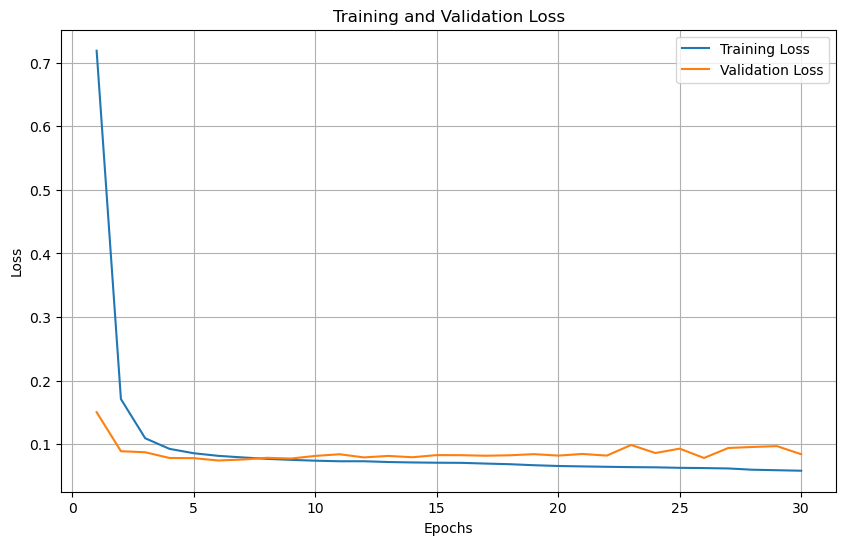

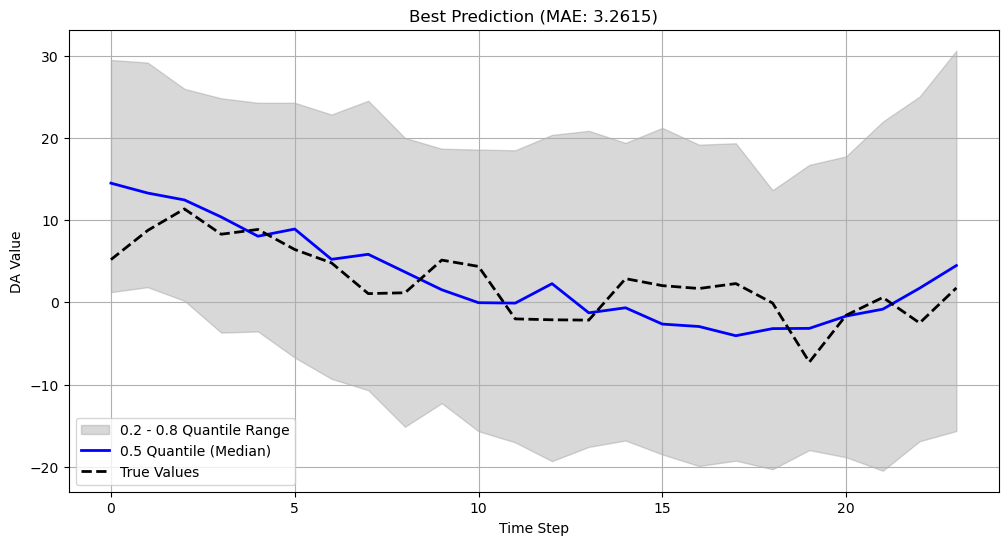

MAE: 3.2615
Pinball Loss: 8.6343
Coverage: 1.0000


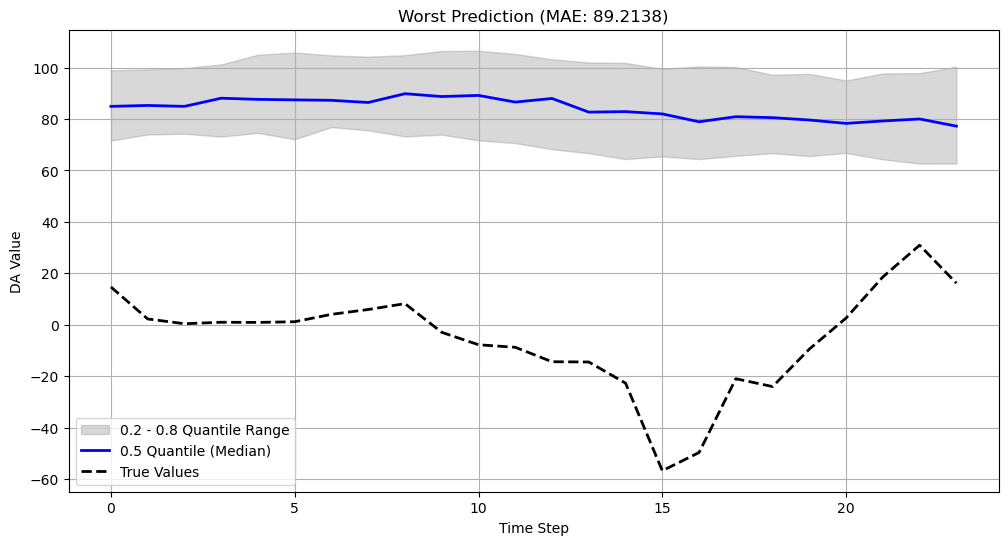

MAE: 89.2138
Pinball Loss: 125.6026
Coverage: 0.0000
Average MAE: 39.2398
--------------------------------------------------
Training model for target: Diff
--------------------------------------------------
usable_hours: 12455
Epoch [1/30], Training Loss: 0.6708, Validation Loss: 0.1325
Epoch [2/30], Training Loss: 0.1302, Validation Loss: 0.0653
Epoch [3/30], Training Loss: 0.0838, Validation Loss: 0.0610
Epoch [4/30], Training Loss: 0.0747, Validation Loss: 0.0579
Epoch [5/30], Training Loss: 0.0706, Validation Loss: 0.0591
Epoch [6/30], Training Loss: 0.0670, Validation Loss: 0.0599
Epoch [7/30], Training Loss: 0.0638, Validation Loss: 0.0666
Epoch [8/30], Training Loss: 0.0612, Validation Loss: 0.0676
Epoch [9/30], Training Loss: 0.0595, Validation Loss: 0.0646
Epoch [10/30], Training Loss: 0.0581, Validation Loss: 0.0644
Epoch [11/30], Training Loss: 0.0574, Validation Loss: 0.0661
Epoch [12/30], Training Loss: 0.0568, Validation Loss: 0.0715
Epoch [13/30], Training Loss: 0.0563,

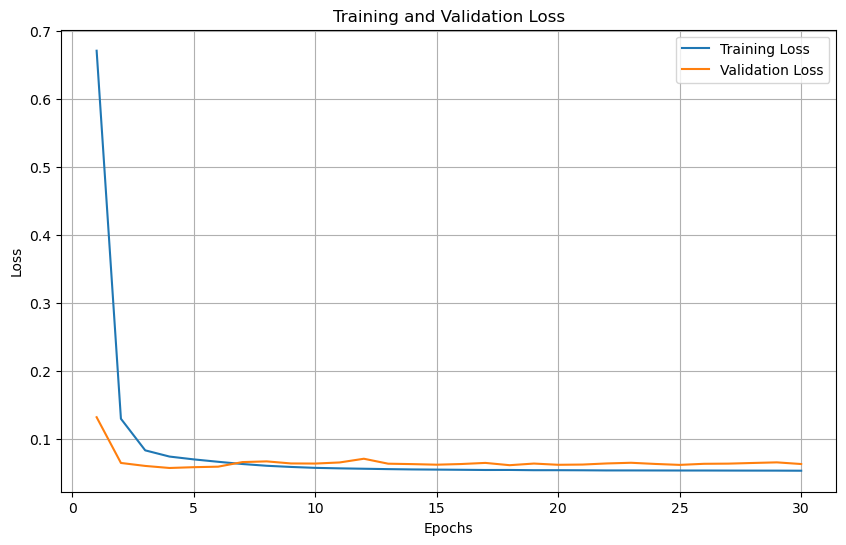

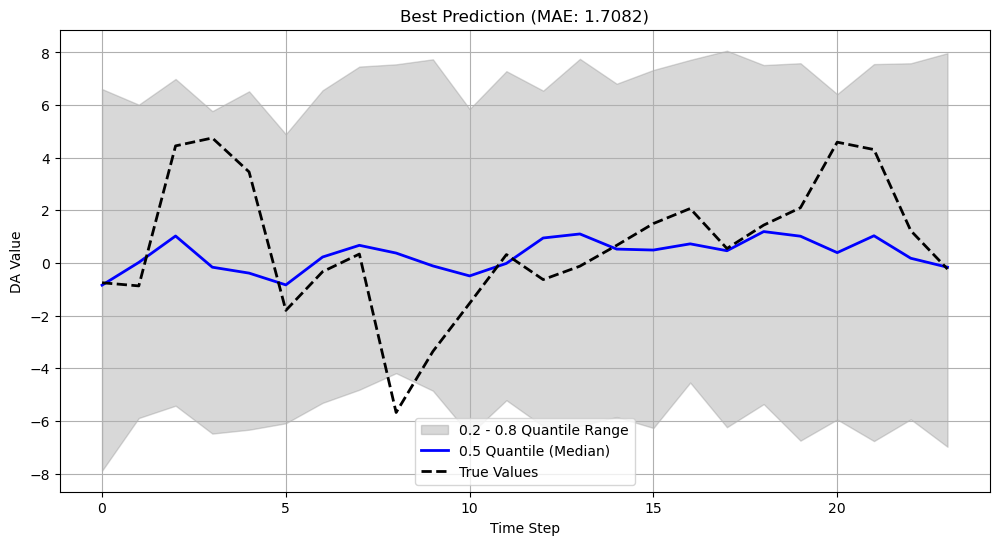

MAE: 1.7082
Pinball Loss: 3.5011
Coverage: 0.9583


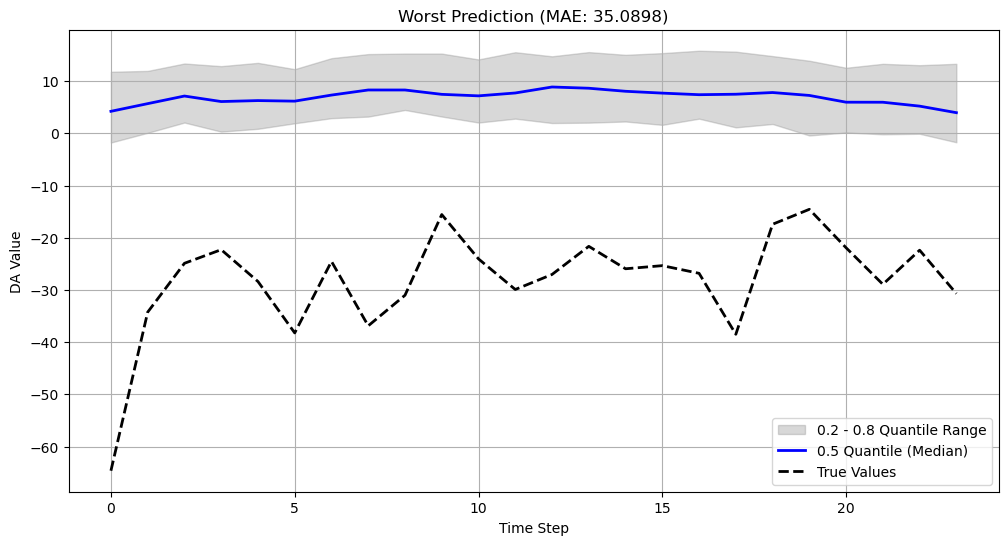

MAE: 35.0898
Pinball Loss: 49.6515
Coverage: 0.0000
Average MAE: 8.0383


In [31]:

for target_col in target_cols:
    print("--------------------------------------------------")
    print(f"Training model for target: {target_col}")
    print("--------------------------------------------------")
    # Prepare datasets with dense and spaced inputs
    (
        train_dense_past,
        train_spaced_past,
        train_future,
        train_pca,
        train_targets,
        val_dense_past,
        val_spaced_past,
        val_future,
        val_pca,
        val_targets,
        test_dense_past,
        test_spaced_past,
        test_future,
        test_pca,
        test_targets,
        target_scaler,
    ) = prepare_data(
        file_path=file_path,
        dense_lookback=dense_lookback,
        spaced_lookback=spaced_lookback,
        forecast_horizon=forecast_horizon,
        future_cols=future_cols,
        target_col=target_col,
        spaced=True,
        step_growth_factor=1,
    )

    # Create DataLoaders
    train_loader = DataLoader(
        list(zip(train_dense_past, train_spaced_past, train_future, train_pca, train_targets)),
        batch_size=64,
        shuffle=True,
    )
    val_loader = DataLoader(
        list(zip(val_dense_past, val_spaced_past, val_future, val_pca, val_targets)),
        batch_size=64,
        shuffle=False,
    )
    test_loader = DataLoader(
        list(zip(test_dense_past, test_spaced_past, test_future, test_pca, test_targets)),
        batch_size=1,
        shuffle=False,
    )

    # Initialize model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model2 = SpacedLSTM(
        dense_input_size=train_dense_past.shape[2],
        spaced_input_size=train_spaced_past.shape[2],
        future_input_size=len(future_cols),
        pca_input_size=train_pca.shape[1],
        hidden_size=128,
        num_layers=2,
        dropout=0.3,
        dense_horizons=dense_lookback,
        spaced_horizons=train_spaced_past.shape[1],
        forecast_horizon=forecast_horizon,
        quantiles=quantiles,
    ).to(device)

    # Optimizer
    optimizer2 = torch.optim.AdamW(model2.parameters(), lr=0.0005, weight_decay=1e-4)

    # Train model
    spaced_model, train_losses, val_losses = train_and_val(
        train_loader, val_loader, num_epochs=30, model=model2, optimizer=optimizer2, quantiles=quantiles, device=device
    )
    # # Predict
    forecast, true = predict_model(spaced_model, test_loader, target_scaler, quantiles=quantiles, forecast_horizon=24, device=device, spaced=True)

    # # Plot results
    plot_forecasts(forecast, true, quantiles=quantiles, forecast_horizon=24)


--------------------------------------------------
Training model for target: DA
--------------------------------------------------
usable_hours: 12455
Epoch [1/50], Training Loss: 0.6815, Validation Loss: 0.1993
Epoch [2/50], Training Loss: 0.1937, Validation Loss: 0.1572
Epoch [3/50], Training Loss: 0.1439, Validation Loss: 0.1258
Epoch [4/50], Training Loss: 0.1318, Validation Loss: 0.1113
Epoch [5/50], Training Loss: 0.1259, Validation Loss: 0.1245
Epoch [6/50], Training Loss: 0.1233, Validation Loss: 0.1120
Epoch [7/50], Training Loss: 0.1207, Validation Loss: 0.1126
Epoch [8/50], Training Loss: 0.1185, Validation Loss: 0.1123
Epoch [9/50], Training Loss: 0.1163, Validation Loss: 0.1130
Epoch [10/50], Training Loss: 0.1139, Validation Loss: 0.1121
Epoch [11/50], Training Loss: 0.1107, Validation Loss: 0.1252
Epoch [12/50], Training Loss: 0.1067, Validation Loss: 0.1241
Epoch [13/50], Training Loss: 0.1029, Validation Loss: 0.1088
Epoch [14/50], Training Loss: 0.0987, Validation Lo

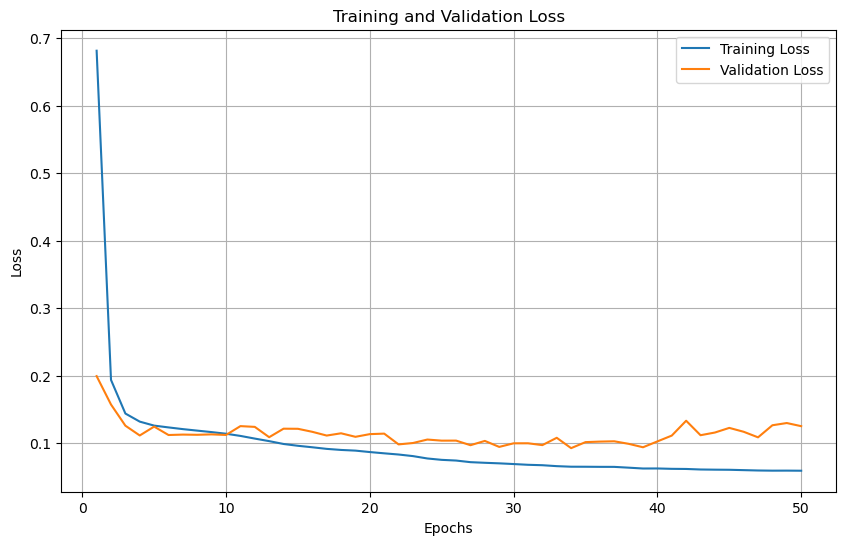

NameError: name 'np' is not defined

In [24]:
val_length = 200  # Length of validation data to plot
begin_val_index = -val_length  # Start index for slicing validation data
end_val_index = None  # End index (None means up to the last point)



for target_col in target_cols:
    print("--------------------------------------------------")
    print(f"Training model for target: {target_col}")
    print("--------------------------------------------------")
    # Prepare datasets with dense and spaced inputs
    (
        train_dense_past,
        train_spaced_past,
        train_future,
        train_pca,
        train_targets,
        val_dense_past,
        val_spaced_past,
        val_future,
        val_pca,
        val_targets,
        test_dense_past,
        test_spaced_past,
        test_future,
        test_pca,
        test_targets,
        target_scaler,
    ) = prepare_data(
        file_path=file_path,
        dense_lookback=dense_lookback,
        spaced_lookback=spaced_lookback,
        forecast_horizon=forecast_horizon,
        future_cols=future_cols,
        target_col=target_col,
        spaced=True,
        step_growth_factor=1,
    )

    # Adjust validation dataset length for plotting
    val_dense_past_plot = val_dense_past[begin_val_index:end_val_index]
    val_spaced_past_plot = val_spaced_past[begin_val_index:end_val_index]
    val_future_plot = val_future[begin_val_index:end_val_index]
    val_pca_plot = val_pca[begin_val_index:end_val_index]
    val_targets_plot = val_targets[begin_val_index:end_val_index]

    # Create DataLoaders
    train_loader = DataLoader(
        list(zip(train_dense_past, train_spaced_past, train_future, train_pca, train_targets)),
        batch_size=64,
        shuffle=True,
    )
    val_loader = DataLoader(
        list(zip(val_dense_past, val_spaced_past, val_future, val_pca, val_targets)),
        batch_size=64,
        shuffle=False,
    )
    test_loader = DataLoader(
        list(zip(test_dense_past, test_spaced_past, test_future, test_pca, test_targets)),
        batch_size=1,
        shuffle=False,
    )

    # Initialize model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model2 = SpacedLSTM(
        dense_input_size=train_dense_past.shape[2],
        spaced_input_size=train_spaced_past.shape[2],
        future_input_size=len(future_cols),
        pca_input_size=train_pca.shape[1],
        hidden_size=128,
        num_layers=2,
        dropout=0.3,
        dense_horizons=dense_lookback,
        spaced_horizons=train_spaced_past.shape[1],
        forecast_horizon=forecast_horizon,
        quantiles=quantiles,
    ).to(device)

    # Optimizer
    optimizer2 = torch.optim.AdamW(model2.parameters(), lr=0.0005, weight_decay=1e-4)

    # Train model
    spaced_model, train_losses, val_losses = train_and_val(
        train_loader, val_loader, num_epochs=50, model=model2, optimizer=optimizer2, quantiles=quantiles, device=device
    )
    # Predict
    forecast, true = predict_model(
        spaced_model, test_loader, target_scaler, quantiles=quantiles, forecast_horizon=24, device=device, spaced=True
    )

    # Plot specific validation length
    forecast_plot = forecast[begin_val_index:end_val_index]
    true_plot = true[begin_val_index:end_val_index]
    assert forecast_plot.shape[2] == forecast_horizon, "Forecast horizon mismatch in forecast_plot."
    assert true_plot.shape[1] == forecast_horizon, "Forecast horizon mismatch in true_plot."

    plot_forecasts(forecast_plot, true_plot, quantiles=quantiles, forecast_horizon=24)

    # Plot forecasts
    plot_forecasts(forecast_plot, true_plot, quantiles=quantiles, forecast_horizon=val_length)


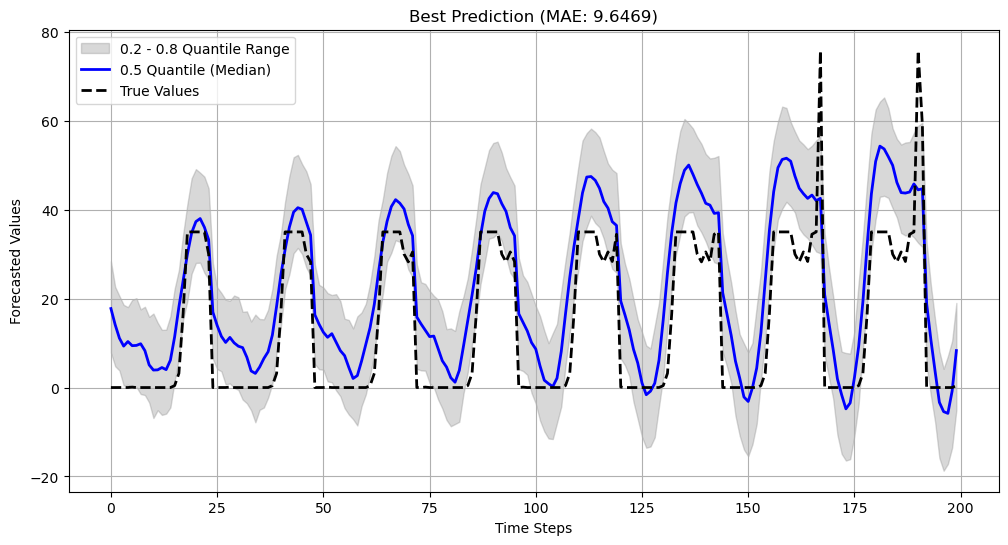

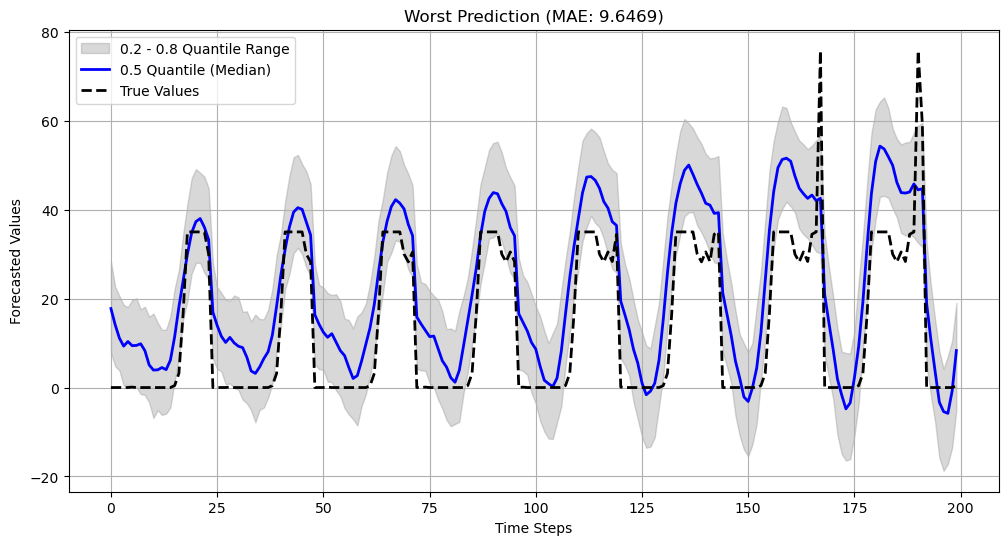

In [26]:
import numpy as np
def concatenate_hours(forecasts, true_values, num_hours):
    """
    Concatenates consecutive 24-hour forecasts and true values into a single sequence.

    Args:
        forecasts (ndarray): Predicted values of shape [num_samples, num_quantiles, forecast_horizon].
        true_values (ndarray): True values of shape [num_samples, forecast_horizon].
        num_hours (int): Desired number of consecutive hours.

    Returns:
        concatenated_forecasts (ndarray): Concatenated forecasts of shape [num_quantiles, num_hours].
        concatenated_true_values (ndarray): Concatenated true values of shape [num_hours].
    """
    num_days = num_hours // 24  # Full days
    remaining_hours = num_hours % 24  # Partial day hours

    # Concatenate full days
    concatenated_forecasts = np.concatenate(forecasts[:num_days, :, :], axis=1)
    concatenated_true_values = np.concatenate(true_values[:num_days, :], axis=0)

    # Add remaining hours from the next day
    if remaining_hours > 0:
        concatenated_forecasts = np.concatenate(
            [concatenated_forecasts, forecasts[num_days, :, :remaining_hours]], axis=1
        )
        concatenated_true_values = np.concatenate(
            [concatenated_true_values, true_values[num_days, :remaining_hours]], axis=0
        )

    return concatenated_forecasts, concatenated_true_values


# Define the desired number of hours
num_hours = 200

# Concatenate forecasts and true values for continuous plotting
forecast_200, true_200 = concatenate_hours(forecast, true, num_hours)

# Plot the 200-hour forecast vs. true values
plot_forecasts(forecast_200[None, :, :], true_200[None, :], quantiles=quantiles, forecast_horizon=num_hours)


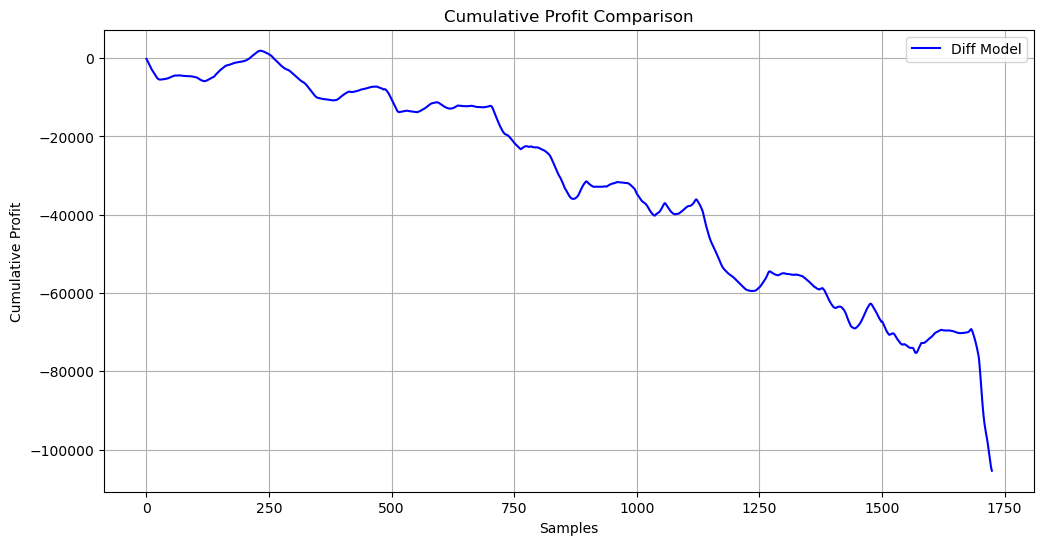

Sign Prediction Accuracy: 44.43%


In [42]:

def revenues_with_shorting(forecasts, targets):
    if isinstance(forecasts, torch.Tensor):
        forecasts = forecasts.cpu().numpy()
    if isinstance(targets, torch.Tensor):
        targets = targets.cpu().numpy()

    # Align shapes by squeezing unnecessary dimensions
    forecasts = forecasts.squeeze()  # Shape: (3, 24) or (24,) depending on the data
    targets = targets.squeeze()  # Shape: (24,)

    # Ensure forecasts and targets are 2D for compatibility
    if forecasts.ndim == 1:
        forecasts = forecasts.reshape(1, -1)
    if targets.ndim == 1:
        targets = targets.reshape(1, -1)

    # Determine if the sign is correct for each point
    sign_correct = (forecasts * targets) > 0

    # Calculate gains/losses
    gains = np.abs(targets) * (2 * sign_correct - 1)

    # Total revenue is the sum of these gains
    return np.sum(gains)

def calculate_sign_accuracy(test_loader, target_scaler, spaced_model, device):
    """
    Calculate the sign prediction accuracy for the Diff model over the entire test set.

    Args:
        test_loader (DataLoader): DataLoader for test data.
        target_scaler (MinMaxScaler): Scaler used to inverse transform target predictions.
        spaced_model (nn.Module): The trained Diff model.
        device (torch.device): Device to run calculations on ('cpu' or 'cuda').

    Returns:
        sign_accuracy (float): Percentage of samples where predicted and actual signs match.
    """
    spaced_model.eval()
    total_samples = 0
    correct_signs = 0

    with torch.no_grad():
        for dense_inputs, spaced_inputs, future_inputs, pca_inputs, targets in test_loader:
            # Move inputs to device
            dense_inputs, spaced_inputs, future_inputs, pca_inputs, targets = (
                dense_inputs.to(device).float(),
                spaced_inputs.to(device).float(),
                future_inputs.to(device).float(),
                pca_inputs.to(device).float(),
                targets.to(device).float(),
            )

            # Predict using the Diff model
            forecasts = spaced_model(dense_inputs, spaced_inputs, future_inputs, pca_inputs)

            # Rescale predictions and targets
            forecasts_rescaled = target_scaler.inverse_transform(forecasts.cpu().numpy().reshape(-1, forecasts.shape[-1]))
            targets_rescaled = target_scaler.inverse_transform(targets.cpu().numpy().reshape(-1, targets.shape[-1]))

            # Adjust dimensions for comparison
            targets_rescaled = targets_rescaled.squeeze()  # Shape: (24,)
            forecasts_rescaled = forecasts_rescaled.mean(axis=0)  # Average over quantiles for shape alignment

            # Calculate sign accuracy
            sign_match = (np.sign(forecasts_rescaled) == np.sign(targets_rescaled))
            correct_signs += np.sum(sign_match)
            total_samples += sign_match.size

    # Calculate accuracy
    sign_accuracy = correct_signs / total_samples * 100
    return sign_accuracy



def calculate_cumulative_profit(test_loader, target_scaler, spaced_model, quantiles, device):
    """
    Calculate cumulative profit for the Diff model over the entire test set.

    Args:
        test_loader (DataLoader): DataLoader for test data.
        target_scaler (MinMaxScaler): Scaler used to inverse transform target predictions.
        spaced_model (nn.Module): The trained Diff model.
        quantiles (list): List of quantiles for predictions.
        device (torch.device): Device to run calculations on ('cpu' or 'cuda').

    Returns:
        cumulative_profit_diff (list): Cumulative profit for Diff model.
        cumulative_profit_da_id (list): Cumulative profit for DA-ID model.
    """
    spaced_model.eval()
    profit_diff = []
    profit_da_id = []

    with torch.no_grad():
        for dense_inputs, spaced_inputs, future_inputs, pca_inputs, targets in test_loader:
            # Move inputs to device
            dense_inputs, spaced_inputs, future_inputs, pca_inputs, targets = (
                dense_inputs.to(device).float(),
                spaced_inputs.to(device).float(),
                future_inputs.to(device).float(),
                pca_inputs.to(device).float(),
                targets.to(device).float(),
            )

            # Predict using the Diff model
            forecasts = spaced_model(dense_inputs, spaced_inputs, future_inputs, pca_inputs)

            # Reshape to 2D for inverse transformation
            forecasts_reshaped = forecasts.cpu().numpy().reshape(-1, forecasts.shape[-1])
            targets_reshaped = targets.cpu().numpy().reshape(-1, targets.shape[-1])

            # Rescale predictions and targets
            predictions_rescaled = target_scaler.inverse_transform(forecasts_reshaped)
            targets_rescaled = target_scaler.inverse_transform(targets_reshaped)

            # Reshape back for profit calculation
            predictions_rescaled = predictions_rescaled.reshape(forecasts.shape)
            targets_rescaled = targets_rescaled.reshape(targets.shape)

            # # Compute DA-ID predictions (assumed available)
            # da_predictions, id_predictions = get_da_id_predictions(dense_inputs, spaced_inputs, future_inputs, pca_inputs)
            # da_id_diff = da_predictions - id_predictions

            # Calculate profit for Diff model
            profit_diff.append(revenues_with_shorting(predictions_rescaled, targets_rescaled))

            # # Calculate profit for DA-ID model
            # profit_da_id.append(revenues_with_shorting(da_id_diff, targets_rescaled))

    # Compute cumulative profit
    cumulative_profit_diff = np.cumsum(profit_diff)
    # cumulative_profit_da_id = np.cumsum(profit_da_id)

    return cumulative_profit_diff   #, cumulative_profit_da_id



# Compute cumulative profits
cumulative_profit_diff = calculate_cumulative_profit(
    test_loader, target_scaler, spaced_model, quantiles, device
)

# Plot cumulative profits
plt.figure(figsize=(12, 6))
plt.plot(cumulative_profit_diff, label="Diff Model", color="blue")
plt.title("Cumulative Profit Comparison")
plt.xlabel("Samples")
plt.ylabel("Cumulative Profit")
plt.legend()
plt.grid(True)
plt.show()


# Calculate and display sign accuracy
sign_accuracy = calculate_sign_accuracy(test_loader, target_scaler, spaced_model, device)
print(f"Sign Prediction Accuracy: {sign_accuracy:.2f}%")

